# SENTIMENT ANALYSIS FOR TECH NEWS

# Importing Dependencies

In [2]:
import pandas as pd
import numpy as np

# misc
import datetime
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
import nltk.sentiment.vader 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA 
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import re
 

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud
from beautifultable import BeautifulTable
from termcolor import colored
from matplotlib.pyplot import figure

# model
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,recall_score,precision_score,classification_report,roc_curve, auc
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import pickle

C:\Users\yamid\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\yamid\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\yamid\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [3]:
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yamid\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yamid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yamid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
reddit = praw.Reddit(client_id='4aPdCwDpU_20aLTRN_oPCg',
                client_secret ='7i9v7Bzs87ZDYVnjJzDWD0hZhjDDsQ',
                user_agent='wong9348',
                check_for_async=False)

In [5]:
subreddit = reddit.subreddit('technews')

news = [*subreddit.hot(limit=None)] # hot posts


In [6]:
df_example = pd.read_csv('combine.csv')
df_example.head()

,title,score,id,author,url,upvote_ratio,comms_num,awards,created
0,Parler?€?s amateur coding could come back to h...,27414,kvw02g,LeSpatula,https://arstechnica.com/information-technology...,0.92,1037,33,13/1/2021 1:20
1,Brazil will fine Apple a second time for not i...,21777,pwlldq,kry_some_more,https://appleinsider.com/articles/21/09/27/bra...,0.97,847,15,28/9/2021 1:08
2,YouTube Will Now Show Ads On All Videos Even I...,21631,jxwpos,SnooBooks5387,https://www.forbes.com/sites/johnkoetsier/2020...,0.93,2297,18,21/11/2020 4:23
3,The DeLorean might be coming back as an electr...,21370,l2b27t,afrcnc,https://electrek.co/2021/01/21/delorean-coming...,0.96,689,43,22/1/2021 7:50
4,Employees are feeling burned over broken work-...,19626,nhl0oy,Mcnst,https://theconversation.com/employees-are-feel...,0.96,2039,16,21/5/2021 13:34


### Data Understanding

In [7]:
# Checking the shape of the dataframe
df_example.shape

(1932, 9)

In [8]:
df_example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932 entries, 0 to 1931
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1932 non-null   object 
 1   score         1932 non-null   int64  
 2   id            1932 non-null   object 
 3   author        1884 non-null   object 
 4   url           1932 non-null   object 
 5   upvote_ratio  1932 non-null   float64
 6   comms_num     1932 non-null   int64  
 7   awards        1932 non-null   int64  
 8   created       1932 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 136.0+ KB


### Changing title to string

In [9]:
df_example = df_example.astype({"title": "string"})

In [10]:
# Checking column wise to check for the presence of null values
df_example.isnull().sum()

title            0
score            0
id               0
author          48
url              0
upvote_ratio     0
comms_num        0
awards           0
created          0
dtype: int64

# Sentiment Analysis with Vader

### Example

In [11]:
# EXAMPLE Sentiment analysis of sentences with Vader
sia = SIA()
pos_text = "Vader is awesome"
cap_pos_text = "Vader is AWESOME!" # captilization and ! increases the effect
neg_text = "Vader is bad"

print(sia.polarity_scores(pos_text))
print(sia.polarity_scores(cap_pos_text))
print(sia.polarity_scores(neg_text))

{'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.281, 'pos': 0.719, 'compound': 0.729}
{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}


### The tech news

In [12]:
res = [*df_example['title'].apply(sia.polarity_scores)]
sentiment_df = pd.DataFrame.from_records(res)
news = pd.concat([df_example["title"], sentiment_df], axis=1, join='inner')
news.head()

,title,neg,neu,pos,compound
0,Parler?€?s amateur coding could come back to h...,0.234,0.766,0.000,-0.4696
1,Brazil will fine Apple a second time for not i...,0.000,0.886,0.114,0.2023
2,YouTube Will Now Show Ads On All Videos Even I...,0.000,0.887,0.113,0.1680
3,The DeLorean might be coming back as an electr...,0.000,1.000,0.000,0.0000
4,Employees are feeling burned over broken work-...,0.114,0.700,0.186,0.0000


# Choosing the threshold

In [13]:
THRESHOLD = 0.1

conditions = [
    (news['compound'] <= -THRESHOLD),
    (news['compound'] > -THRESHOLD) & (news['compound'] < THRESHOLD),
    (news['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
news['label'] = np.select(conditions, values)



In [14]:
news.head()

,title,neg,neu,pos,compound,label
0,Parler?€?s amateur coding could come back to h...,0.234,0.766,0.000,-0.4696,neg
1,Brazil will fine Apple a second time for not i...,0.000,0.886,0.114,0.2023,pos
2,YouTube Will Now Show Ads On All Videos Even I...,0.000,0.887,0.113,0.1680,pos
3,The DeLorean might be coming back as an electr...,0.000,1.000,0.000,0.0000,neu
4,Employees are feeling burned over broken work-...,0.114,0.700,0.186,0.0000,neu


# Vader on individual words

In [13]:
sentence0 = news.title.iloc[0]
words0 = news.title.iloc[0].split()

pos_list = []
neg_list = []
neu_list = []

for word in words0:
  if (sia.polarity_scores(word)['compound']) >= THRESHOLD:
    pos_list.append(word)
  elif (sia.polarity_scores(word)['compound']) <= -THRESHOLD:
    neg_list.append(word)
  else:
    neu_list.append(word)                

print('Positive:',pos_list)        
print('Neutral:',neu_list)    
print('Negative:',neg_list) 
score = sia.polarity_scores(sentence0)

print(f"\nThis sentence is {score['neg']}% negative")
print(f"This sentence is {score['neu']}% neutral")
print(f"This sentence is {score['pos']}% positive")
print(f"The compound value : {score['compound']} <= THRESHOLD")
sentiment = news.label.iloc[0]

if sentiment == "neu":
    sentiment = "neutral"
elif sentiment == "pos":
    sentiment = "positive"
else:
    sentiment = "negative"
    
print(f"This sentence is " + sentiment)

news.label.value_counts()


Positive: []
Neutral: ['Parler?€?s', 'amateur', 'coding', 'could', 'come', 'back', 'to', 'Capitol', 'Hill', 'rioters']
Negative: ['haunt']

This sentence is 0.234% negative
This sentence is 0.766% neutral
This sentence is 0.0% positive
The compound value : -0.4696 <= THRESHOLD
This sentence is negative


neu    810
neg    591
pos    531
Name: label, dtype: int64

# Showing the number of neural, positive and negative post

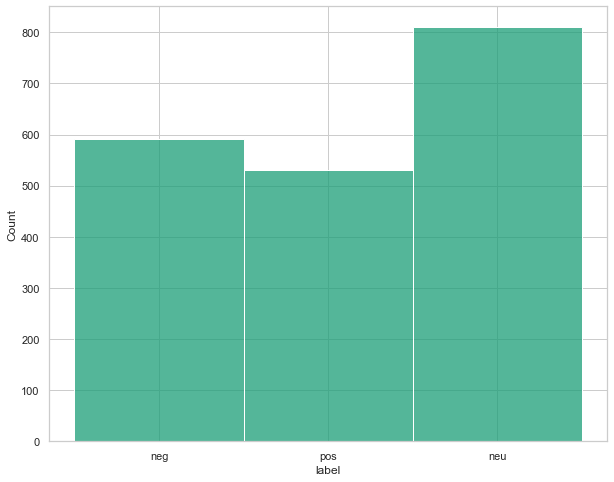

In [14]:
sns.histplot(news.label);

# View sampled posts based on labels

In [15]:
def news_title_output(df, label):
  res = df[df['label'] == label].title.values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
news_sub = news.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
news_title_output(news_sub, "pos")

print("\nNeutral news")
news_title_output(news_sub, "neu")

print("\nNegative news")
news_title_output(news_sub, "neg")

Positive news
Eastern Caribbean dollar goes digital, a help for unbanked
Porsche's first Super Bowl ad since 1997 debuts all-electric Taycan with half the range and double the price of Tesla model S
For a day, Microsoft's market cap leaps over Apple's, now the world's most valuable company
Hailed ?€?high tech?€? robot turns out to be a man in a suit
Google announces new tools to help with virtual education during the pandemic

Neutral news
Tesla will build 'the nation's most sustainable' solar neighborhood in Southeast Austin
Your boss may be watching you, surveillance technology and WFH
AI emotion-detection software tested on Uyghurs
New Apple iOS 14.5 Beta Feature Notifies Users if They're Being Tracked
Esports body calls for disability gaming tournaments

Negative news
Apple reportedly planned to open its own primary healthcare clinics and employ doctors in a project codenamed 'Casper,' which stalled because key people quit
Russia announces it will impose restrictions on Twitter
Goo

# Data Preprocessing

**The Preprocessing steps taken are:**
1. **Tokenize:** Extract the tokens from string of characters
2. **Lower Casing:** Each text is converted to lowercase.
3. **Removing Non-Alphabets:** Replacing characters except Alphabets with a space.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. We remove the text that is stop word and the length of text that is more than one will be considered.
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

### Cleaning up sentence

In [16]:
def preprocess(text):
    stopWords = set(stopwords.words('english'))
  # remove single quote and dashes
#   text = text.replace("'", "").replace("-", "").lower()

#   # split on words only
#   tk = nltk.tokenize.RegexpTokenizer(r'\w+')
#   tokens = tk.tokenize(text)
    alphaPattern = '[^a-zA-Z]'
    text = re.sub(alphaPattern, " ", text) # Replace all non alphabets.
    text = nltk.word_tokenize(text) # tokenize
#     text = [word for word in text if word.isalnum()] # check characters are alphanumeric
    text = [lemmatizer.lemmatize(word.lower()) for word in text] # lemmas - convert a word to its base form and each text 
                                                             # is converted to lowercase
    
  # remove stop words
    list_word = []
    #words = [w for w in text if not w in stopWords]
    for w in text:
        if not w in stopWords:
            if len(w) > 1: # the word such as "u" will be eliminate
                words = w
                list_word.append(words)
            
    return list_word

print(preprocess(news["title"][0]))

['parler', 'amateur', 'coding', 'could', 'come', 'back', 'haunt', 'capitol', 'hill', 'rioter']


In [17]:
example = news[news['label'] != "neu"]
processed_text = []
for x in example["title"]:
    x = preprocess(x)
    x = ' '.join(x)
    processed_text.append(x)


In [18]:
example.loc[example.label == "pos", "label"] = 1
example.loc[example.label == "neg", "label"] = -1
example = example.astype({"label": int})

C:\Users\yamid\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [19]:
processed_text

['parler amateur coding could come back haunt capitol hill rioter',
 'brazil fine apple second time including charger iphone',
 'youtube show ad video even creator want',
 'massachusetts verge becoming first state ban police use facial recognition',
 'plague inc rolling new mode fight contain outbreak',
 'scientist develop laser system remove cancer without damaging healthy tissue',
 'california ready pull plug gas vehicle',
 'treating like robot amazon worker seek union',
 'youtube removing dislike discourages troll unhelpful user',
 'three four american say facebook making society worse many identify platform major source disinformation',
 'coronavirus crisis prof internet public utility',
 'blue origin employee resigned day ceo jeff bezos flew space',
 'department energy back five advanced nuclear reactor concept',
 'nokia win nasa contract put network moon',
 'hey siri getting pulled shortcut make easy record police',
 'radioactive diamond battery run year',
 'italy fine amazon rec

### Showing Positive and Negative words

In [20]:
def tokens_2_words(df, label):
    # subset titles based on label
    titles = df[df['label'] == label].title
    # apply our custom tokenize function to each title
    tokens = titles.apply(preprocess)
    # join nested lists into a single list
    words = list(chain.from_iterable(tokens))
    return words

pos_words = tokens_2_words(news, "pos")
neg_words = tokens_2_words(news, "neg")

table = BeautifulTable()
table.columns.append(pos_words,header=colored("Positive Words","blue",attrs=['bold']))
table.columns.append(neg_words,header=colored("Negative Words","blue",attrs=['bold']))
table.set_style(BeautifulTable.STYLE_BOX_ROUNDED)
print(table)

╭───────────────────┬────────────────────╮
│  Positive Words   │   Negative Words   │
├───────────────────┼────────────────────┤
│      brazil       │       parler       │
├───────────────────┼────────────────────┤
│       fine        │      amateur       │
├───────────────────┼────────────────────┤
│       apple       │       coding       │
├───────────────────┼────────────────────┤
│      second       │       could        │
├───────────────────┼────────────────────┤
│       time        │        come        │
├───────────────────┼────────────────────┤
│     including     │        back        │
├───────────────────┼────────────────────┤
│      charger      │       haunt        │
├───────────────────┼────────────────────┤
│      iphone       │      capitol       │
├───────────────────┼────────────────────┤
│      youtube      │        hill        │
├───────────────────┼────────────────────┤
│       show        │       rioter       │
├───────────────────┼────────────────────┤
│        ad

# Visualize tokens

### Printing out top 20 common positive words

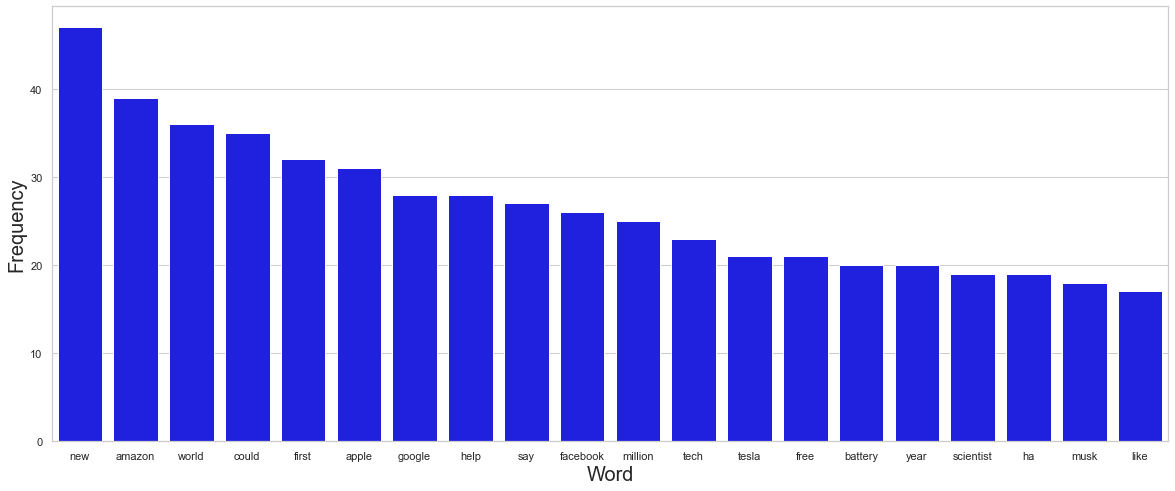

In [34]:
pos_freq = nltk.FreqDist(pos_words)
df_frequency = pd.DataFrame({"Word":list(pos_freq.keys()), "Frequency":list(pos_freq.values())})
df_frequency = df_frequency.nlargest(columns="Frequency", n=20)
plt.figure(figsize=(20,8))
ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
ax.set_ylabel("Frequency",fontsize=20)
ax.set_xlabel("Word",fontsize=20)
plt.xticks(rotation='horizontal')
plt.show()

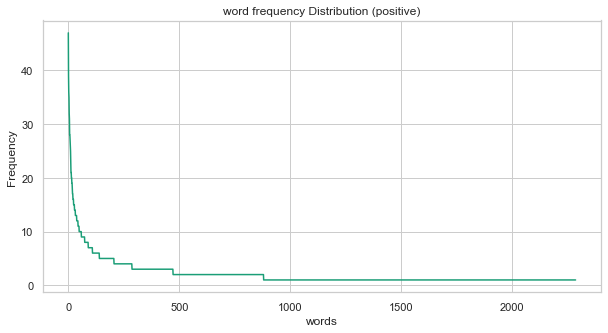

In [114]:
y_val = [x[1] for x in pos_freq.most_common()]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("words")
plt.ylabel("Frequency")
plt.title("word frequency Distribution (positive)")
plt.show()

### Printing out top 20 common negative words

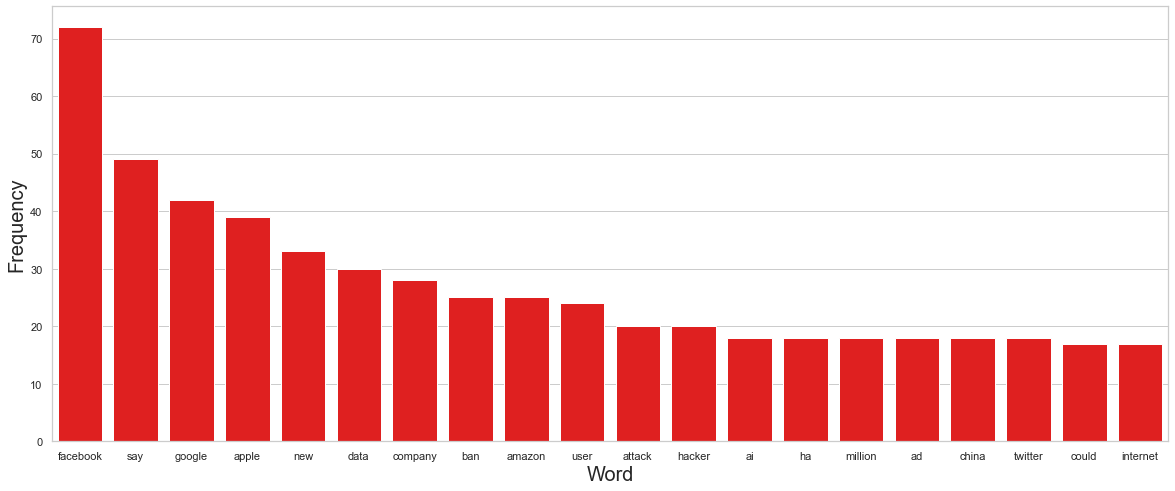

In [115]:
neg_freq = nltk.FreqDist(neg_words)
df_frequency = pd.DataFrame({"Word":list(neg_freq.keys()), "Frequency":list(neg_freq.values())})
df_frequency = df_frequency.nlargest(columns="Frequency", n=20)
plt.figure(figsize=(20,8))
ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'red')
ax.set_ylabel("Frequency",fontsize=20)
ax.set_xlabel("Word",fontsize=20)
plt.xticks(rotation='horizontal')
plt.show()

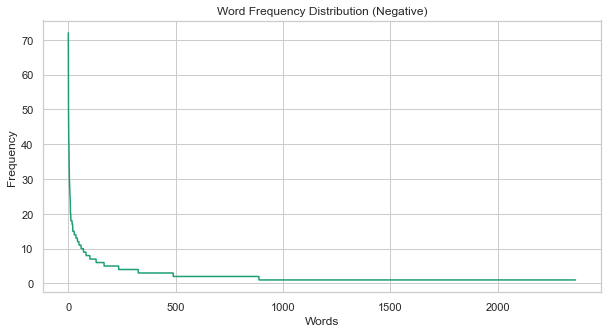

In [116]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

# Word Clouds

In [117]:
def plot_word_cloud(words, colormap, stopwords = [], max_words = 100):
  text = " ".join(word for word in words)
  # generate word cloud 
  wordcloud = WordCloud(width=1000, height = 600,
                        max_words = max_words,
                        colormap=colormap,
                        stopwords = stopwords,
                        background_color="black").generate(text)

  # Display the generated image:
  plt.figure( figsize=(20,10), facecolor='k' )
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off");

In [118]:
def extract_sentence_from_word(df, word, label, num = 3):
  contains_word = df['title'].str.contains(r"\b{}\b".format(word), case=False) # matches the word only
  label_type = df['label'] == label
  sent_list = df.loc[contains_word & label_type].title.values
  print("\n".join(sent for sent in sent_list[:num]))

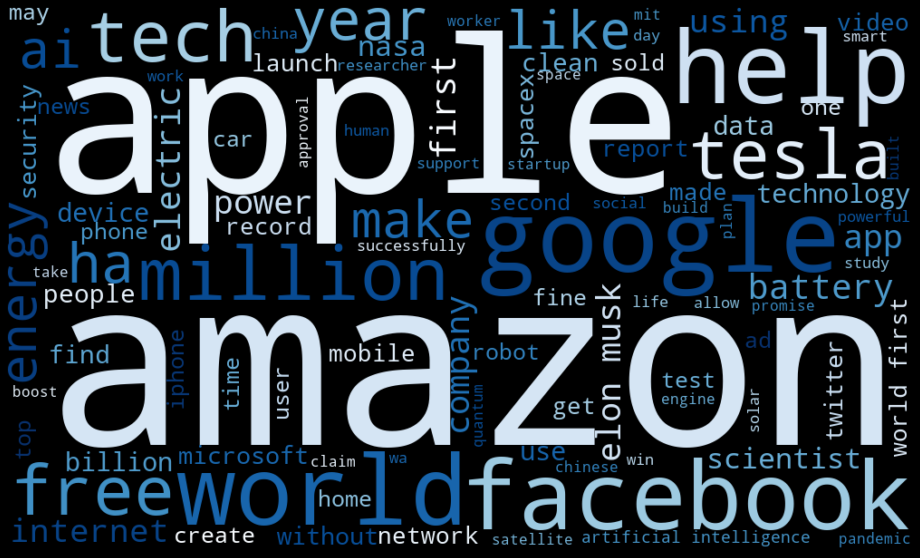

In [119]:
plot_word_cloud(pos_words, "Blues", ["new", "could", "say","u"])

In [120]:
extract_sentence_from_word(news, "apple", "pos")

Brazil will fine Apple a second time for not including a charger with iPhone 13
Florida man who had ?€?no idea what AFib was?€? saved by Apple Watch during holiday travel
Apple removes app promoting private parties in pandemic


In [121]:
extract_sentence_from_word(news, "microsoft", "pos")

Microsoft declares its underwater data center test was a success
Microsoft remote work study: Average length of workweek has increased 10% during pandemic
Microsoft quietly removes pledge to share 95% of app revenue on the Microsoft Store


In [122]:
extract_sentence_from_word(news, "tech", "pos")

Some of Europe's top tech investors are adding a 'sustainability clause' to start-up deal terms
Lithuanian defence ministry urges people to 'throw away' Chinese phones after discovering censorship tools | Science & Tech News
TRADE U.S. blacklists dozens of Chinese tech firms citing national security concerns


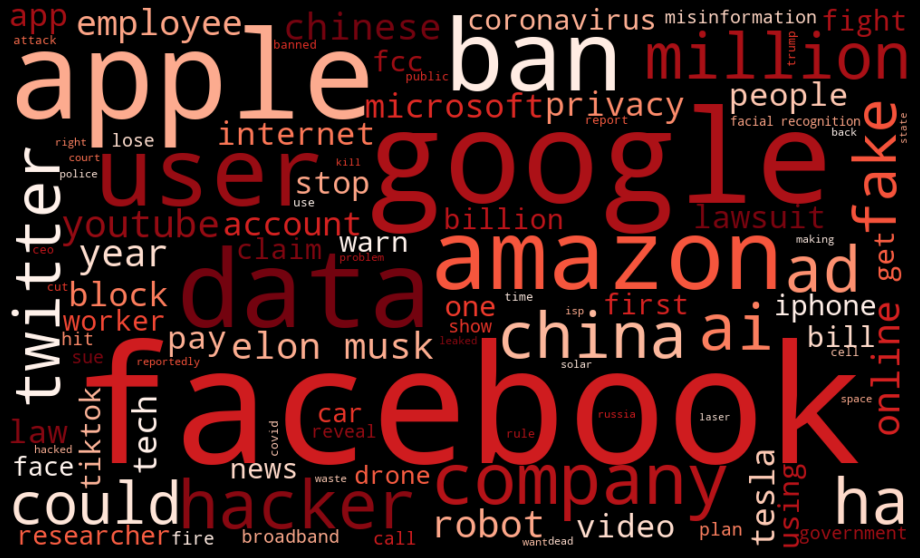

In [123]:
plot_word_cloud(neg_words, "Reds", ["new", "say","u"])

In [124]:
extract_sentence_from_word(news, "ban", "neg", num = 5)

Massachusetts on the verge of becoming first state to ban police use of facial recognition
European Parliament calls for a ban on facial recognition in public spaces
EU artificial intelligence rules will ban 'unacceptable' use
OnlyFans to ban adult material after pressure from payment processors
Twitch will ban people for harassment, even when it doesn?€?t happen on the site


In [125]:
extract_sentence_from_word(news, "amazon", "neg")

Italy fines Amazon record $1.3 bln for abuse of market dominance
Amazon workers were left 'terrified and powerless' after it concealed coronavirus cases, California says
Amazon says workers and applicants fired or barred during marijuana screening are now eligible for employment


In [126]:
extract_sentence_from_word(news, "hacker", "neg")

A hacker who exposed Verkada?€?s surveillance camera snafu has been raided
Elon Musk Reveals Arrested Russian Hacker Targeted Tesla's Nevada Gigafactory with Malware Attack
Hacker steals government ID database for Argentina?€?s entire population


# Splitting the Data

In [127]:
# Splitting the entire set into train and test with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(processed_text, example.label,
                                                    test_size = 0.2,random_state=42)

## TF-IDF Vectorizer

In [128]:
# Fitting TFIDF vectorizer on the train dataset 
vectoriser = TfidfVectorizer(ngram_range=(1,2))
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  10111


### Tranforming the dataset

In [129]:
# Transforming the X_train and X_test dataset on the fitted model
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

## Creating and Evaluating Models

We're creating 3 different types of model for our sentiment analysis problem: 
* **Linear Support Vector Classification (LinearSVC)**
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Logistic Regression (LR)**

Since our dataset is not **skewed**, i.e. it has number of **Positive and Negative** predictions are almost similar. We're choosing **Accuracy** as our evaluation metric. Furthermore, we're plotting the **Confusion Matrix** and **ROC Curve** to get an understanding of how our model is performing on both classification types.

In [130]:
# Creating a method which will take the model object and then predict on the test set and evaluate on Accuracy, 
# Confusion Matrix and ROC Curve

def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

#     categories  = ['Negative','Neutral','Positive']
#     group_names = ["True Negative","False Neutral","False Positive","False Negative","True Neutral","False Positive","False Negative","False Neutral","True Positive"]
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
    plt.title ("ROC Curve")
    #Area under Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_pred
    
 

# LinearSVC Model

              precision    recall  f1-score   support

          -1       0.70      0.87      0.78       126
           1       0.76      0.53      0.62        99

    accuracy                           0.72       225
   macro avg       0.73      0.70      0.70       225
weighted avg       0.73      0.72      0.71       225



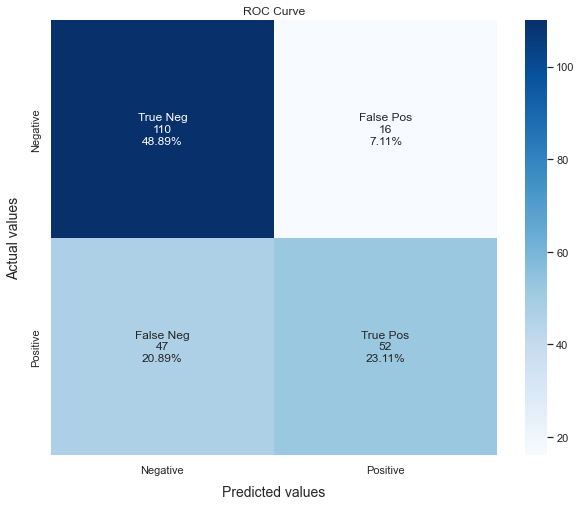

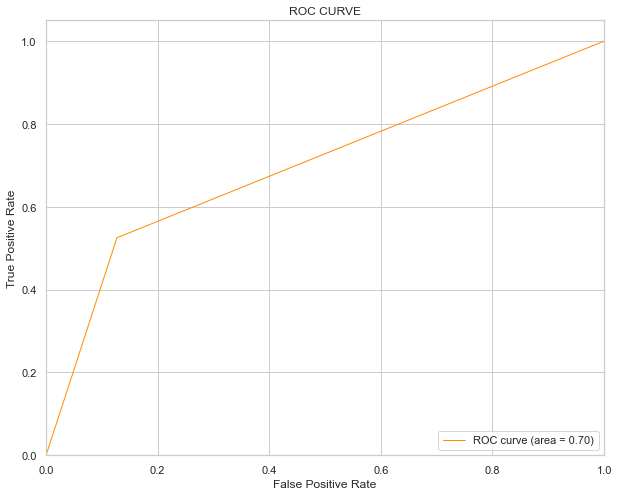

array([ 1, -1,  1, -1,  1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1,
        1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1, -1, -1,
        1,  1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1,
       -1,  1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1, -1,
        1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
        1,  1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
       -1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1,
        1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1,
        1,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1, -1, -1,
        1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1,
       -1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1])

In [131]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
model_Evaluate(svc)

# BernoulliNB Model

              precision    recall  f1-score   support

          -1       0.60      0.98      0.74       126
           1       0.84      0.16      0.27        99

    accuracy                           0.62       225
   macro avg       0.72      0.57      0.51       225
weighted avg       0.70      0.62      0.53       225



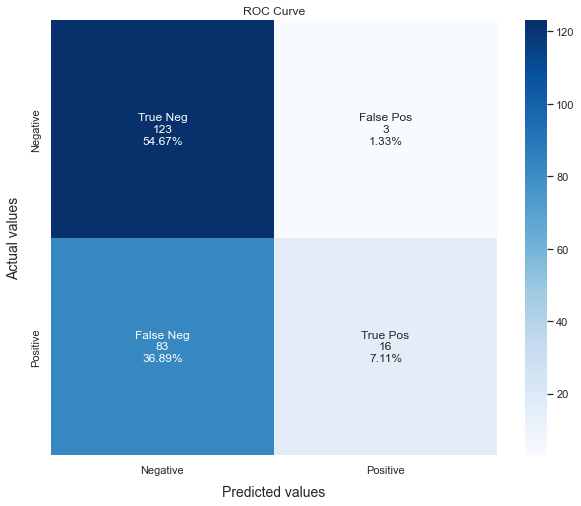

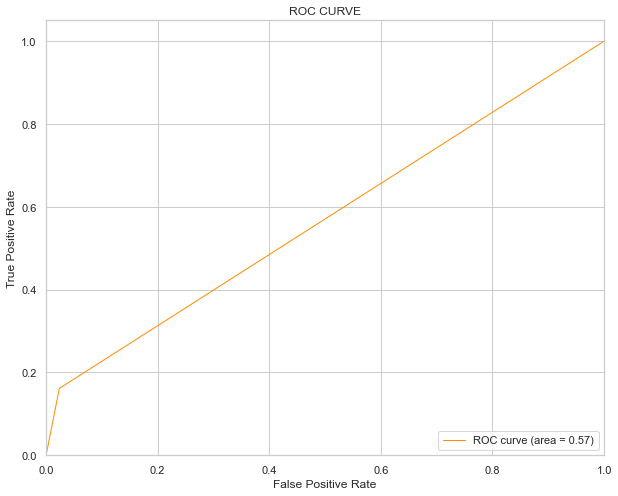

array([-1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1,
       -1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1])

In [132]:
# Created a Bernoulli Naive Bayes model with default parameters and then evaluating the model
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

# Logistic Regression Model

              precision    recall  f1-score   support

          -1       0.72      0.83      0.77       126
           1       0.72      0.59      0.65        99

    accuracy                           0.72       225
   macro avg       0.72      0.71      0.71       225
weighted avg       0.72      0.72      0.71       225



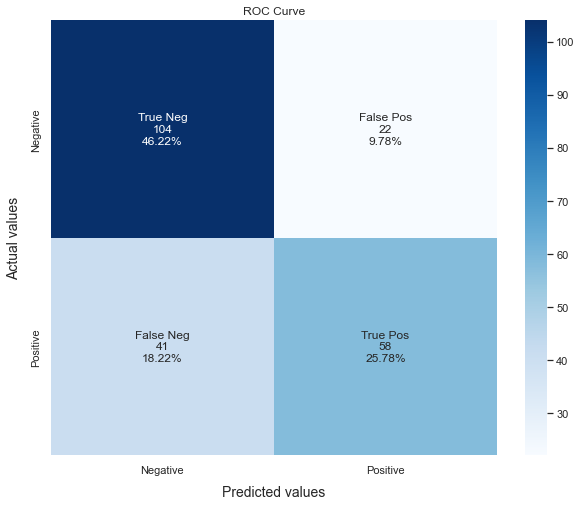

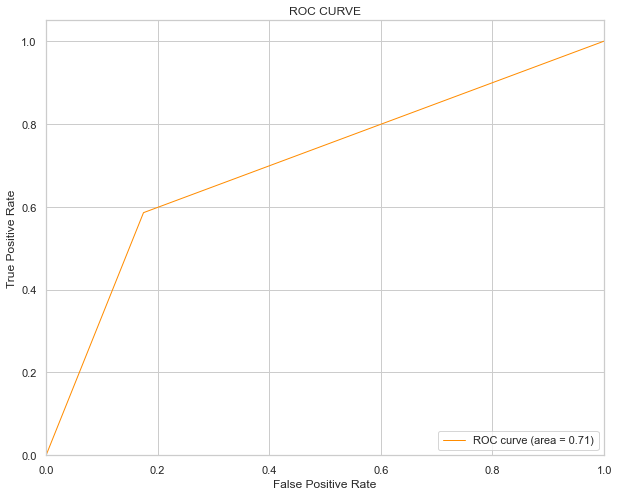

In [133]:
# Created a Logistic Regression model with regularization parameter and max iteration limit and then evaluating the model
LRmodel = LogisticRegression(C = 1, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_test_pred = model_Evaluate(LRmodel)


In [134]:
# Printing the positive and negative sentiment on the test data based on logistic regression model
print("Positive Sentiment Percentage : {}%".format(round(np.count_nonzero(y_test_pred == 1)/len(y_test_pred)*100,2)))

print("Negative Sentiment Percentage : {}%".format(round(np.count_nonzero(y_test_pred == -1)/len(y_test_pred)*100,2)))

Positive Sentiment Percentage : 35.56%
Negative Sentiment Percentage : 64.44%


# Saving the model
We're using **PICKLE** to save **Vectoriser and Logistic Regression Model** for later use.

In [135]:
# Storing the vectorizer object and Logistic Regression object in pickle files for later use

file = open('vectoriser.pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

## Using the Model

To use the model for **Sentiment Prediction** we need to import the **Vectoriser** and **LR Model** using **Pickle**.

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.
The text whose sentiment has to be predicted however must be preprocessed.

In [136]:
# Method to load the models from pickle file
def load_models():  
       
    # Load the vectoriser.
    file = open('vectoriser.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel


# Method to perform tfidf vectorizer on unseen data and then using the model loaded from pickle file to predict 
# whether positive or negative and also the probability along with it.
def predict(vectoriser, model, text):
    finaldata = []
    
    
    processed_text = []
    for x in text:
        x = preprocess(x)
        x = ' '.join(x)
        processed_text.append(x)
    
    
    textdata = vectoriser.transform(processed_text)
    sentiment = model.predict(textdata)
    
    # print(model.classes_)
    sentiment_prob = model.predict_proba(textdata)
    
    for index,tweet in enumerate(text):
        if sentiment[index] == 1:
            sentiment_probFinal = sentiment_prob[index][1]
        else:
            sentiment_probFinal = sentiment_prob[index][0]
            
        sentiment_probFinal2 = "{}%".format(round(sentiment_probFinal*100,2))
        finaldata.append((tweet, sentiment[index], sentiment_probFinal2))
           
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(finaldata, columns = ['text','sentiment', 'Probability(Confidence Level)'])
    df = df.replace([-1,1], ["Negative","Positive"])
    return df

In [137]:
# Text to classify should be in a list.
text = ["I hate reddit",
        "Apple launches Android app to address AirTags tracker fears",
        "YouTube Co-Founder Thinks Removing Dislike Count Is a Wrong Decision",
        "Trump blocked by Twitter and Facebook.",
       "Snapchat will permanently ban Trump’s account",
       "Facebook is finally banning anti-vaxxer misinformation"]

In [138]:
# First we load model method and predict the text by passing the tfidf vectorizer as parameter
# Output is printing the dataframe containing text, sentiment and the probability confidence.
vectoriser, LRmodel = load_models()
df = predict(vectoriser, LRmodel, text)
df

,text,sentiment,Probability(Confidence Level)
0,I hate reddit,Negative,56.45%
1,Apple launches Android app to address AirTags ...,Positive,52.02%
2,YouTube Co-Founder Thinks Removing Dislike Cou...,Negative,63.29%
3,Trump blocked by Twitter and Facebook.,Negative,68.56%
4,Snapchat will permanently ban Trump’s account,Negative,70.01%
5,Facebook is finally banning anti-vaxxer misinf...,Negative,66.02%


### The pie chart of positive VS negative

C:\Users\yamid\AppData\Local\Temp/ipykernel_13776/3435494496.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


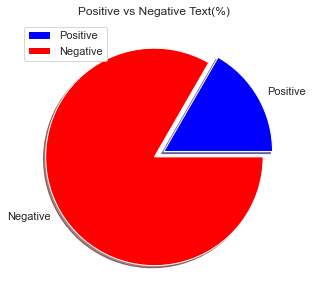

In [139]:
positive = round(np.count_nonzero(df['sentiment'] == "Positive")/len(df['sentiment'])*100,2)
negative = round(np.count_nonzero(df['sentiment'] == "Negative")/len(df['sentiment'])*100,2)

labels = ['Positive','Negative']
values = np.array([positive,negative])
myexplode = [0.1, 0]
mycolors = ["blue", "red"]

fig,ax = plt.subplots(figsize=(6,5))
ax.pie(values, labels = labels, explode = myexplode, shadow = True, colors = mycolors)
ax.legend()
ax.set_title("Positive vs Negative Text(%)")
fig.show()

# Using the Model - Excel Upload

### Below is using the csv format dataset which is upload by user and then the positive and negative news will be shown

In [140]:
# Importing the excel dataset
data = pd.read_csv("technews.csv")
data.head()

,title,score,id,author,url,upvote_ratio,comms_num,awards,created
0,"Amazon VP Resigns, Calls Company ‘Chickenshit’...",56899,gdd9d8,ourlifeintoronto,https://www.vice.com/en_us/article/z3bjpj/amaz...,0.94,1746,10,2020-05-04 23:07:31
1,Robinhood plummets back down to a one-star rat...,34718,lakvbj,fudge_u,https://www.theverge.com/2021/2/1/22261178/rob...,0.96,699,34,2021-02-02 10:10:19
2,YouTube Co-Founder Thinks Removing Dislike Cou...,30278,quli6k,Some_won,https://beebom.com/youtube-co-founder-thinks-r...,0.95,930,21,2021-11-16 01:23:45
3,Twitter hides Trump tweet attacking Supreme Co...,29068,jn69ys,coldseaside,https://techcrunch.com/2020/11/02/twitter-trum...,0.89,1262,39,2020-11-03 15:43:47
4,Parler CEO says even his lawyers are abandonin...,24386,kuuq6y,fudge_u,https://www.theverge.com/2021/1/10/22223956/pa...,0.94,1446,15,2021-01-11 12:01:45


In [141]:
data.shape

(976, 9)

In [174]:
# We only take the sentence data
text = list(data['title'])

In [175]:
def predict_Excel(vectoriser, model, text):
    finaldata = []

    processed_text = []
    for x in text:
        x = preprocess(x)
        x = ' '.join(x)
        processed_text.append(x)
    
    
    textdata = vectoriser.transform(processed_text)
    sentiment = model.predict(textdata)
    
    
    # print(model.classes_)
    sentiment_prob = model.predict_proba(textdata)
    
    for index,tweet in enumerate(text):
        if sentiment[index] == 1: # If the text is positive text
            sentiment_probFinal = sentiment_prob[index][1] # then take the probability of the positive
        else:
            sentiment_probFinal = sentiment_prob[index][0] # else negative
            
        sentiment_probFinal2 = "{}%".format(round(sentiment_probFinal*100,2))
        finaldata.append((tweet, sentiment[index], sentiment_probFinal2))
           
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(finaldata, columns = ['text','sentiment', 'Probability(Confidence Level)'])
    df = df.replace([-1,1], ["Negative","Positive"])
    return df

In [176]:
vectoriser, LRmodel = load_models()
df = predict_Excel(vectoriser, LRmodel, text)

C:\Users\yamid\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\yamid\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\yamid\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [177]:
df.sort_values(by=['Probability(Confidence Level)'],ascending=False,inplace=True)
df.head()

,text,sentiment,Probability(Confidence Level)
10,Facebook bans all mentions of ‘stop the steal’,Negative,78.16%
642,Facebook bans face mask ads to curb coronaviru...,Negative,74.82%
541,Artificial Intelligence Finds A Strong New Ant...,Positive,73.51%
930,Facebook exec blames society for COVID misinfo...,Negative,72.91%
648,Facebook bans academics who researched ad tran...,Negative,72.22%


C:\Users\yamid\AppData\Local\Temp/ipykernel_13776/242641309.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


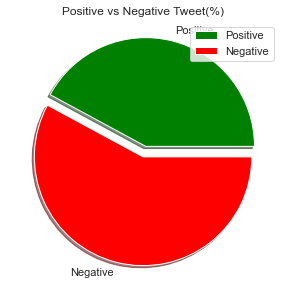

In [178]:
positive = round(np.count_nonzero(df['sentiment'] == "Positive")/len(df['sentiment'])*100,2)
negative = round(np.count_nonzero(df['sentiment'] == "Negative")/len(df['sentiment'])*100,2)
labels = ['Positive','Negative']
values = np.array([positive,negative])
myexplode = [0.1, 0]
mycolors = ["green", "red"]

fig,ax = plt.subplots(figsize=(6,5))
ax.pie(values, labels = labels, explode = myexplode, shadow = True, colors = mycolors)
ax.legend()
ax.set_title("Positive vs Negative Tweet(%)")
fig.show()